# Récupération de flux solaires avec pvlib


La librairie `pvlib` est un outil puissant pour le calcul de la production électrique de systèmes photovoltaïques. On se propose ici d'en utiliser une partie à des fins de reconstitution des flux solaires. Le code démontre une utilisation d'un fichier météorologique "EPW" permettant, à partir des flux solair horizontal et normal incident, de calculer le flux direct et diffus sur une paroi d'orientation et d'inclinaison donnée.

<AxesSubplot:>

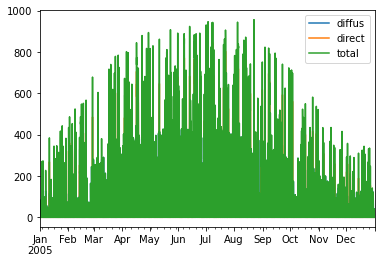

In [2]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
from pvlib import solarposition
from pvlib import irradiance
import pandas as pd

def fc_flux_diffus_direct(global_horizontal, diffus_horizontal, 
                    latitude, longitude, 
                    inclinaison, orientation, pression):
    
    # inclinaison=np.ones(len(global_horizontal))*inclinaison
    # orientation=np.ones(len(global_horizontal))*orientation
    
    # determination de la hauteur solaire et de l'angle d'incidence avec pvlib
    tz = 'Europe/Paris'
    times = pd.date_range('2005-01-01 00:00:00', '2006-01-01 00:00:00', inclusive='left', freq='H', tz=tz)
    solpos = solarposition.get_solarposition(times, latitude, longitude)
    # on le fait pour tous les pas de temps
    azimut, hauteur_solaire = solpos["azimuth"].values, solpos["elevation"].values
    zenith, app_zen = solpos["zenith"].values, solpos["apparent_zenith"].values
    
    # calcul du DNI et Direct
    direct_normal = irradiance.disc(global_horizontal.values, zenith, times, pressure=pression.values)['dni']
    direct = irradiance.beam_component(inclinaison, orientation, zenith, azimut, direct_normal.values)
    
    # Masse atmospherique (Kasten and Young 1989)
    hauteur_solaire = np.where(hauteur_solaire< 0, 0, hauteur_solaire)
    ksi_z = 90-hauteur_solaire
    airmass = ( np.cos(np.radians(ksi_z)) + 0.50572*np.power(96.07995-ksi_z,-1.6364) )**-1
    I0=1368 # on peut la faire varier avec le temps
        
    diffus = irradiance.perez(inclinaison, orientation, diffus_horizontal, direct_normal.values, 
                              I0, app_zen, azimut, airmass,  return_components=False)
    
    return diffus, direct


# on lit un ficher epw et on le met dans un dataframe
# pour ce faire nous avons besoin des noms des colonnes : ils sont ci-apres
colnames = ['year', 'month', 'day', 'hour', 'minute', 'data_source_unct',
            'temp_air', 'temp_dew', 'relative_humidity',
            'atmospheric_pressure', 'etr', 'etrn', 'ghi_infrared', 'ghi',
            'dni', 'dhi', 'global_hor_illum', 'direct_normal_illum',
            'diffuse_horizontal_illum', 'zenith_luminance',
            'wind_direction', 'wind_speed', 'total_sky_cover',
            'opaque_sky_cover', 'visibility', 'ceiling_height',
            'present_weather_observation', 'present_weather_codes',
            'precipitable_water', 'aerosol_optical_depth', 'snow_depth',
            'days_since_last_snowfall', 'albedo',
            'liquid_precipitation_depth', 'liquid_precipitation_quantity']

# lecture du ficher + affectation des noms de colonnes
fichier_epw='./src/LE_HAVRE_OCTEVILLE-hour.epw'
data_meteo=pd.read_csv(fichier_epw, sep=",", skiprows = 8, header=None, names=colnames)

# ensuite on lit juste l'entete du EPW pour avoir lat/lon
header_epw = pd.read_csv(fichier_epw, sep=",", nrows = 1, header=None)
latitude= header_epw[6][0]
longitude = header_epw[7][0]
# Les "parametres solaires" heure par heure

# le nord est a 0° /le sud a 180°
inclinaison, orientation = 0, 0
diffus, direct = fc_flux_diffus_direct(data_meteo['dni'], data_meteo['dhi'], latitude, longitude, inclinaison, orientation, data_meteo['atmospheric_pressure'])

# on cree un dataframe pour stocker les donnees
df=pd.DataFrame()
tz = 'Europe/Paris' # il faut donner le fuseau horaire tz
df.index = pd.date_range('2005-01-01 00:00:00', '2006-01-01 00:00:00', inclusive='left', freq='H', tz=tz)

# ensuite on ajoute les deux vecteurs terme a terme avec np (permet d'obtenir float+NaN = float)
total = np.add(diffus,direct)

df['diffus'] = diffus.values
df['direct'] =  direct
df['total'] =  total.values

# on remplace les NaN
for elt in df.keys():
    df[elt] = df[elt].replace(np.nan, 0)

df.plot()

À vous de jouer : sur l'année, quelle est la part de l'énergie annuelle fournie par le diffus et par le direct ? (faites la somme et vérifiez la valeur de l'ordre de $\sim 10^3$ kWh/m²/an)

In [31]:
print(df.direct.sum()/1000)
print(df.diffus.sum()/1000)

413.2520027080483
603.9778592730288


À vous de jouer : tracez le flux moyen sur une journée (partez avec un `df.groupby(df.index.hour)...` ?) et évaluez la fraction flux diffus/flux total en toute heure de cette journée moyenne.

In [32]:
# solution-astuce : cela se fait en une ligne car on peut utiliser df.groupby(df.index.hour).nomdunecle.mean() 
# ...